In [1]:
# 데이터 구성 : Series, DataFrame
import pandas as pd
# 행렬 연산
import numpy as np

# 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib

# Scaling
from sklearn.preprocessing import StandardScaler

# 데이터 분할
from sklearn.model_selection import train_test_split

# 로지스틱 회귀
from statsmodels.api import Logit

# 의사결정나무
from sklearn.tree import DecisionTreeClassifier

# 평가함수
from sklearn.metrics import accuracy_score

# confusion matrix
from sklearn.metrics import confusion_matrix

# column counter
from collections import Counter

import graphviz

from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV
import os

In [94]:
matplotlib.rc("font", family="NanumGothic")
plt.rcParams['axes.unicode_minus']=False
os.environ['PATH']+=os.pathsep+"~/anaconda3/lib/python3.7/site-packages"

In [8]:
import warnings

warnings.filterwarnings("ignore")

# Logistic Regression

In [3]:
df=pd.read_csv("../data/BigData/HMEQ.csv")
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12.0,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4.0,0,0.0,93.811775,0.0,13,29.681827


결측치 개수 확인하기

In [9]:
df.isnull().sum()

BAD          0
LOAN         0
MORTDUE      0
VALUE       14
REASON       0
JOB         81
YOJ        205
DEROG        0
DELINQ      30
CLAGE       37
NINQ        56
CLNO         0
DEBTINC      0
dtype: int64

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3748 entries, 0 to 3747
Data columns (total 13 columns):
BAD        3748 non-null int64
LOAN       3748 non-null int64
MORTDUE    3748 non-null int64
VALUE      3748 non-null float64
REASON     3748 non-null object
JOB        3748 non-null object
YOJ        3748 non-null float64
DEROG      3748 non-null int64
DELINQ     3748 non-null float64
CLAGE      3748 non-null float64
NINQ       3748 non-null float64
CLNO       3748 non-null int64
DEBTINC    3748 non-null float64
dtypes: float64(6), int64(5), object(2)
memory usage: 380.7+ KB


In [24]:
list_cols = df.select_dtypes(include="object").columns

print(list_cols)

for v_col in list_cols:
    print()
    print("변수", v_col, "level 수 = ",Counter(df[v_col]))

Index(['REASON', 'JOB'], dtype='object')

변수 REASON level 수 =  Counter({'DebtCon': 2645, 'HomeImp': 1103})

변수 JOB level 수 =  Counter({'Other': 1525, 'ProfExe': 929, 'Office': 623, 'Mgr': 477, 'Self': 130, 'Sales': 64})


In [10]:
# JOB의 결측치를 "Othre"로 대체
df['JOB'].fillna("Other", inplace=True)

# 다른 결측치의 경우 평균으로 대체
df.fillna(df.mean(), inplace=True)

Split train, test data\
**모델 안정성을 확인하기 위해서 train과 test를 나눠서 사용한다**

In [12]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=1234)
print("train size is {}".format(df_train.shape))
print("test size is {}".format(df_test.shape))


train size is (2623, 13)
test size is (1125, 13)


In [13]:
s=""
for d in df_train.columns:
    s+=d+"+"
    
s

'BAD+LOAN+MORTDUE+VALUE+REASON+JOB+YOJ+DEROG+DELINQ+CLAGE+NINQ+CLNO+DEBTINC+'

In [32]:
df['JOB'].value_counts()

Other      1525
ProfExe     929
Office      623
Mgr         477
Self        130
Sales        64
Name: JOB, dtype: int64

In [18]:
log_model =Logit.from_formula("BAD ~LOAN+MORTDUE+VALUE+C(REASON)+\
C(JOB)+YOJ+DEROG+DELINQ+CLAGE+NINQ+CLNO+DEBTINC", df_train)

log_result = log_model.fit()

print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.237614
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    BAD   No. Observations:                 2623
Model:                          Logit   Df Residuals:                     2606
Method:                           MLE   Df Model:                           16
Date:                Mon, 28 Oct 2019   Pseudo R-squ.:                  0.2257
Time:                        11:17:54   Log-Likelihood:                -623.26
converged:                       True   LL-Null:                       -804.91
Covariance Type:            nonrobust   LLR p-value:                 1.743e-67
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -5.0942      0.560     -9.100      0.000      -6.191      -3.997

* **C(JOB)[T.office], C(JOB)[T.Sales], DEROG, DELINQ, CLAGE, NINQ, CLNO, DEBTINC는 유의수준 0.05에서 유의한 변수이다!**
* 설명력은 0.2258로 낮은 편이다!

예측 및 성능 평가

In [46]:
y_pred = log_result.predict(df_test)

y_pred_class = (y_pred>0.5).astype(int) # 0.5보다 크면 1
y_pred_class.head()

1721    0
822     0
1686    0
789     0
165     0
dtype: int64

In [47]:
y_pred_class.value_counts()

0    1098
1      27
dtype: int64

In [48]:
print("Accuracy : {0:.3f}\n".format(accuracy_score(df_test['BAD'],y_pred_class)))
print("Confusion Matrix: \n{}".format(confusion_matrix(df_test['BAD'],y_pred_class)))

Accuracy : 0.924

Confusion Matrix: 
[[1017    4]
 [  81   23]]


# 결론 도출

    최종 회귀식
**yhat = -5.0942 -0.8256*C(JOB)[T.office] + 1.1323 * C(JOB)[T.Sales]  + ... + 0.1097 * DEBTINC**

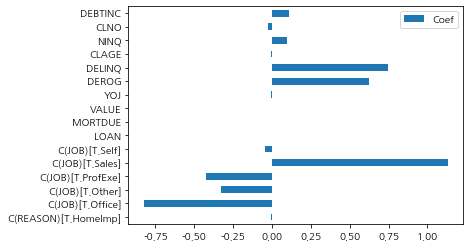

In [50]:
# 설명변수 중요도 
df_logistic_coef = pd.DataFrame({"Coef":log_result.params.values[1:]}, index = log_model.exog_names[1:])
df_logistic_coef.plot.barh(y="Coef")

C(JOB)[T.self] > C(JOB)[T.office] > ... > VALUE

In [51]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
BAD,2623.0,0.091880,0.288911,0.000000,0.000000,0.000000,0.000000,1.000000
LOAN,2623.0,19523.255814,11603.499719,2400.000000,12000.000000,17000.000000,24000.000000,89900.000000
MORTDUE,2623.0,74977.917652,43823.621917,4641.000000,48024.500000,66667.000000,92322.000000,397299.000000
VALUE,2623.0,106575.869755,52774.318088,21144.000000,70691.000000,94216.000000,122301.500000,512650.000000
YOJ,2623.0,9.135439,7.367628,0.000000,3.000000,8.000000,13.000000,36.000000
DEROG,2623.0,0.156310,0.591677,0.000000,0.000000,0.000000,0.000000,10.000000
DELINQ,2623.0,0.285804,0.829764,0.000000,0.000000,0.000000,0.000000,10.000000
CLAGE,2623.0,181.786145,81.919106,0.507115,120.517410,179.240936,229.357226,1168.233561
NINQ,2623.0,0.998503,1.521900,0.000000,0.000000,0.000000,1.028982,13.000000
CLNO,2623.0,21.789173,9.643619,0.000000,15.000000,21.000000,26.000000,71.000000


    변수들간의 scale 차이가 존재함
    따라서, 표준화가 필요함!

## StandardScaler

In [56]:
df_char = df.select_dtypes(include="object")
df_numeric = df.select_dtypes(exclude ="object")

scaler = StandardScaler()
np_numeric_scaled = scaler.fit_transform(df_numeric)
df_numeric_scaled = pd.DataFrame(np_numeric_scaled, columns=df_numeric.columns)

# 범주형데이터는 scaling이 되지 않기 때문에 연속형 변수를 표준화 시킨 후에 컬럼으로 붙인다!
df_scaled = pd.concat([df_numeric_scaled,df_char], axis=1)
df_scaled.head().T

,0,1,2,3,4
BAD,3.14066,3.14066,-0.318404,3.14066,-0.318404
LOAN,-1.55959,-1.55082,-1.50697,-1.4982,-1.4982
MORTDUE,-0.993626,-1.03924,0.60757,-0.897428,0.520156
VALUE,-1.22491,-1.1749,0.260973,-1.09313,0.191721
YOJ,-0.0175628,0.251809,-0.960364,0.386495,-0.690992
DEROG,-0.267462,-0.267462,-0.267462,-0.267462,-0.267462
DELINQ,-0.342558,-0.342558,-0.342558,-0.342558,-0.342558
CLAGE,-0.967342,-1.12205,-1.09493,-1.34468,-1.06059
NINQ,-0.0187758,-0.666629,-0.666629,-0.0187758,-0.666629
CLNO,-1.42835,-1.42835,-0.905133,-0.0679848,-0.905133


In [58]:
df_scaled['BAD']=np.where(df_scaled['BAD']>0,1,0)
df_scaled.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON,JOB
0,1,-1.559587,-0.993626,-1.224910,-0.017563,-0.267462,-0.342558,-0.967342,-0.018776,-1.428350,0.356347,HomeImp,Other
1,1,-1.550817,-1.039240,-1.174897,0.251809,-0.267462,-0.342558,-1.122053,-0.666629,-1.428350,0.329025,HomeImp,Other
2,0,-1.506968,0.607570,0.260973,-0.960364,-0.267462,-0.342558,-1.094930,-0.666629,-0.905133,-0.303684,HomeImp,Office
3,1,-1.498198,-0.897428,-1.093133,0.386495,-0.267462,-0.342558,-1.344679,-0.018776,-0.067985,0.493725,HomeImp,Mgr
4,0,-1.498198,0.520156,0.191721,-0.690992,-0.267462,-0.342558,-1.060586,-0.666629,-0.905133,-0.531456,HomeImp,Office


In [59]:
df_scaled_train, df_scaled_test = train_test_split(df_scaled,
                                                  test_size=0.3,
                                                  random_state=1234)

In [60]:
scaled_log_model =Logit.from_formula("BAD ~LOAN+MORTDUE+VALUE+C(REASON)+\
C(JOB)+YOJ+DEROG+DELINQ+CLAGE+NINQ+CLNO+DEBTINC", df_scaled_train)

scaled_log_result = scaled_log_model.fit()

print(scaled_log_result.summary())

Optimization terminated successfully.
         Current function value: 0.237614
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    BAD   No. Observations:                 2623
Model:                          Logit   Df Residuals:                     2606
Method:                           MLE   Df Model:                           16
Date:                Mon, 28 Oct 2019   Pseudo R-squ.:                  0.2257
Time:                        12:11:34   Log-Likelihood:                -623.26
converged:                       True   LL-Null:                       -804.91
Covariance Type:            nonrobust   LLR p-value:                 1.743e-67
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -2.4815      0.205    -12.111      0.000      -2.883      -2.080

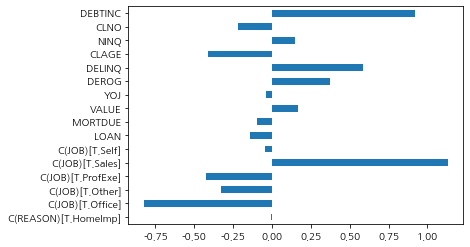

In [62]:
df_log_scaled_coef = pd.DataFrame({"Coef":scaled_log_result.params.values[1:]},
                                 index=scaled_log_model.exog_names[1:])
df_log_scaled_coef.plot.barh(y="Coef", legend=False)

    C(JOB)[T.self] > DEBTINC > ... > YOJ
    표준화를 시킨 뒤에 변수 중요도를 살펴본 결과, 표준화 이전과 그 값이 달라진 것을 확인 할 수 있다!


# Decision Tree

In [68]:
df= pd.read_csv("../data/BigData/HMEQ.csv")
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12.0,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4.0,0,0.0,93.811775,0.0,13,29.681827


In [75]:
df.isnull().sum()

BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64

In [72]:
# JOB의 결측치를 "Othre"로 대체
df['JOB'].fillna("Other", inplace=True)

# 다른 결측치의 경우 평균으로 대체
df.fillna(df.mean(), inplace=True)

dummy데이터 생성

In [73]:
df_raw_dummy = pd.get_dummies(df)
df_raw_dummy.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1700,30548,40320.0,9.0,0,0.0,101.466002,1.0,8,37.113614,0,1,0,0,1,0,0,0
1,1,1800,28502,43034.0,11.0,0,0.0,88.766030,0.0,8,36.884894,0,1,0,0,1,0,0,0
2,0,2300,102370,120953.0,2.0,0,0.0,90.992533,0.0,13,31.588503,0,1,0,1,0,0,0,0
3,1,2400,34863,47471.0,12.0,0,0.0,70.491080,1.0,21,38.263601,0,1,1,0,0,0,0,0
4,0,2400,98449,117195.0,4.0,0,0.0,93.811775,0.0,13,29.681827,0,1,0,1,0,0,0,0


In [82]:
df_x=df_raw_dummy.drop("BAD", axis=1)
df_y=df_raw_dummy['BAD']

dummy데이터 포함된 상태에서 train, test데이터 분리

In [83]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x, df_y, test_size=0.3, random_state=1234)
print("train size is {}".format(df_train_x.shape))
print("test size is {}".format(df_test_x.shape))

print("test size is {}".format(df_test_y.shape))

train size is (2623, 18)
test size is (1125, 18)
test size is (1125,)


In [84]:
tree_uncustomized =  DecisionTreeClassifier(random_state=1234)
tree_uncustomized.fit(df_train_x,df_train_y)

print("Accuracy on training set : {:.3f}".format(tree_uncustomized.score(df_train_x, df_train_y)))
print("Accuracy on test set : {:.3f}".format(tree_uncustomized.score(df_test_x, df_test_y)))

Accuracy on training set : 1.000
Accuracy on test set : 0.932


##### Depth 정하기

In [86]:
train_accuracy =[]; test_accuracy=[]

para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    tree=DecisionTreeClassifier(max_depth=v_max_depth, random_state=1234)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))
    
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth['Depth']=para_depth
df_accuracy_depth['TrainAccuracy']=train_accuracy
df_accuracy_depth['TestAccuracy']=test_accuracy

df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,1,0.926,0.924
1,2,0.931,0.927
2,3,0.934,0.921
3,4,0.937,0.928
4,5,0.940,0.930
5,6,0.941,0.930
6,7,0.947,0.935
7,8,0.951,0.933
8,9,0.957,0.933
9,10,0.960,0.938


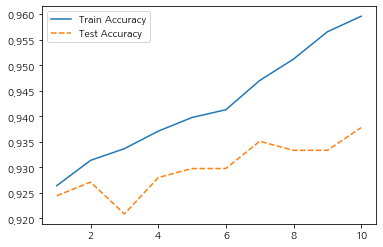

In [89]:
plt.plot(para_depth, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle="--", label="Test Accuracy")
plt.legend()

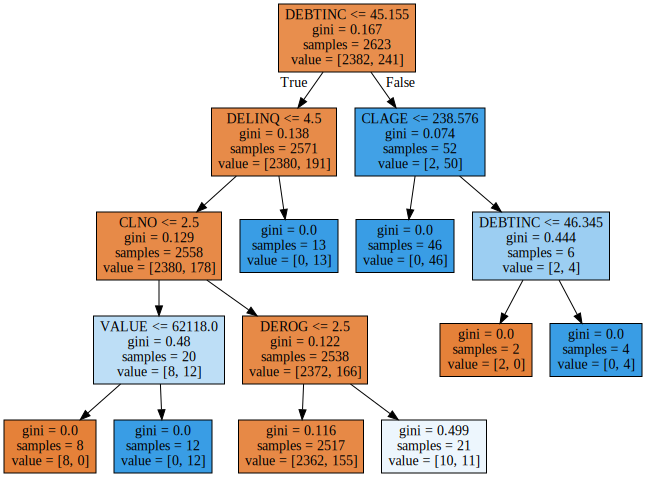

In [100]:
v_feature_name = df_train_x.columns


# 노드의 최소 자료수=8 모델
tree_graph=DecisionTreeClassifier(random_state=1234,max_depth=4)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file="tree_depth.dot", feature_names=v_feature_name, impurity=True, filled=True)

with open("tree_depth.dot") as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

##### min_samples_split 정하기

In [101]:
train_accuracy =[]; test_accuracy=[]

para_split = [n_split*10 for n_split in range(1,11)]

for v_min_samples_split in para_split:
    tree=DecisionTreeClassifier(max_depth=4,
                                min_samples_split=v_min_samples_split,random_state=1234)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))
    
df_accuracy_split = pd.DataFrame()
df_accuracy_split['Split']=para_split
df_accuracy_split['TrainAccuracy']=train_accuracy
df_accuracy_split['TestAccuracy']=test_accuracy

df_accuracy_split.round(3)

,Split,TrainAccuracy,TestAccuracy
0,10,0.936,0.928
1,20,0.936,0.928
2,30,0.933,0.921
3,40,0.933,0.921
4,50,0.933,0.921
5,60,0.933,0.921
6,70,0.933,0.921
7,80,0.933,0.921
8,90,0.933,0.921
9,100,0.933,0.921


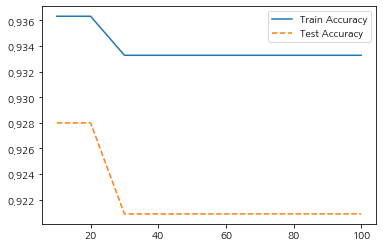

In [102]:
plt.plot(para_split, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle="--", label="Test Accuracy")
plt.legend()

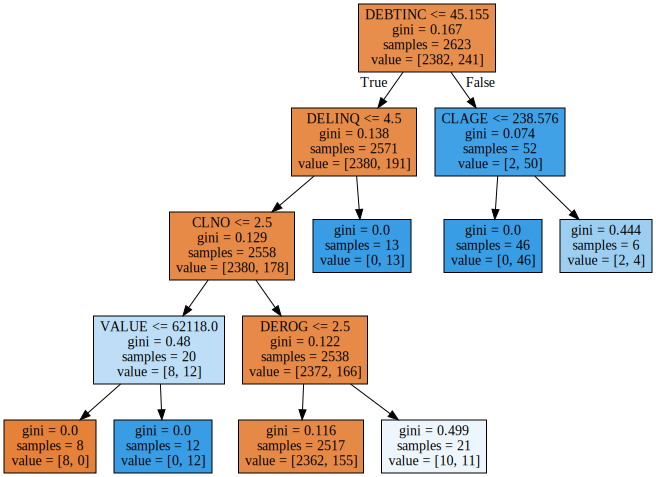

In [104]:
v_feature_name = df_train_x.columns


# 노드의 최소 자료수=8 모델
tree_graph=DecisionTreeClassifier(random_state=1234,max_depth=4,
                                 min_samples_split=20)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file="tree_split.dot", feature_names=v_feature_name, impurity=True, filled=True)

with open("tree_split.dot") as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

##### min_samples_leaf정하기

In [107]:
train_accuracy =[]; test_accuracy=[]

para_leaf = [n_leaf*2 for n_leaf in range(1,11)]

for v_min_samples_leaf in para_leaf:
    tree=DecisionTreeClassifier(max_depth=4,
                                min_samples_split=20,
                                min_samples_leaf=v_min_samples_leaf
                                ,random_state=1234)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))
    
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf['Leaf']=para_leaf
df_accuracy_leaf['TrainAccuracy']=train_accuracy
df_accuracy_leaf['TestAccuracy']=test_accuracy

df_accuracy_leaf.round(3)

,Leaf,TrainAccuracy,TestAccuracy
0,2,0.936,0.928
1,4,0.936,0.928
2,6,0.936,0.928
3,8,0.936,0.928
4,10,0.936,0.928
5,12,0.933,0.921
6,14,0.932,0.917
7,16,0.932,0.919
8,18,0.932,0.919
9,20,0.932,0.919


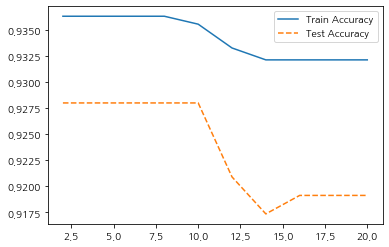

In [108]:
plt.plot(para_leaf, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle="--", label="Test Accuracy")
plt.legend()

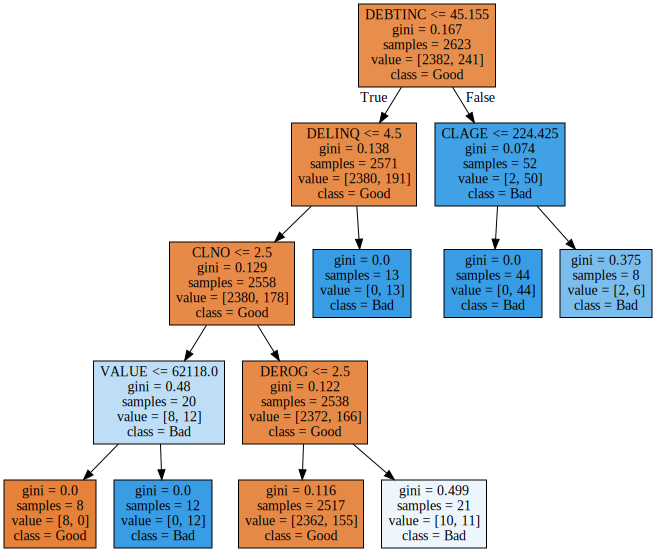

In [110]:
v_feature_name = df_train_x.columns


# 노드의 최소 자료수=8 모델
tree_graph=DecisionTreeClassifier(random_state=1234,max_depth=4,
                                 min_samples_split=20,
                                 min_samples_leaf=8)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file="tree_low.dot", feature_names=v_feature_name, impurity=True, filled=True,
               class_names=['Good','Bad'])

with open("tree_low.dot") as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

##### 최종 모델 선정

In [112]:
tree_final = DecisionTreeClassifier(max_depth=4, min_samples_split=20,
                                   min_samples_leaf=8, random_state=1234)
tree_final.fit(df_train_x, df_train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1234, splitter='best')

최종 모델 시각화

In [4]:
df=pd.read_csv("../data/BigData/IRIS.csv")




train size is (105, 5)
test size is (45, 5)


In [7]:
df.head()

,SEPAL_LENGTH,SEPAL_WIDTH,PETAL_LENGTH,PETAL_WIDTH,SPECIES
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [9]:
df_x=df.drop('SPECIES', axis=1)
df_y = df['SPECIES']
df_train_x, df_test_x,df_train_y, df_test_y = train_test_split(df_x, df_y, test_size=0.3, random_state=1234)
print("train size is {}".format(df_train_x.shape))
print("test size is {}".format(df_test_x.shape))

train size is (105, 4)
test size is (45, 4)


In [10]:
tree_final = DecisionTreeClassifier(min_samples_split=10,
                                   min_samples_leaf=5)
tree_final.fit(df_train_x, df_train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [12]:
tree_final.score(df_test_x, df_test_y)

0.9555555555555556

In [13]:
tree_final = DecisionTreeClassifier(min_samples_split=10,
                                   min_samples_leaf=5, criterion="entropy")
tree_final.fit(df_train_x, df_train_y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [14]:
tree_final.score(df_test_x, df_test_y)

0.9555555555555556

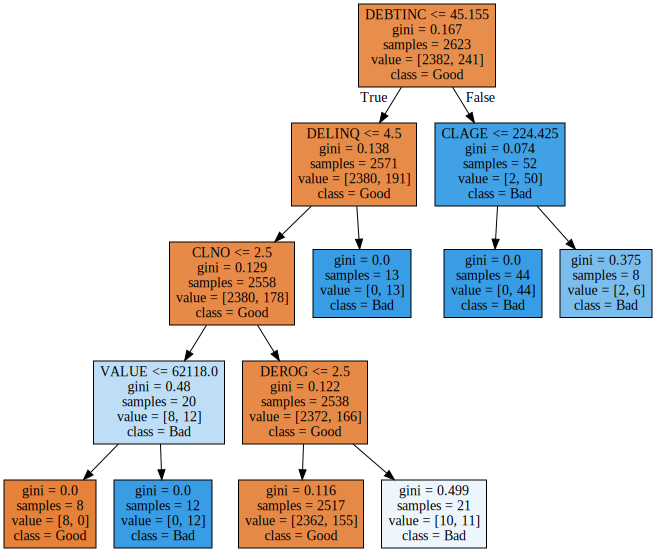

In [114]:

export_graphviz(tree_final, out_file="tree_final.dot", feature_names=v_feature_name, impurity=True, filled=True,
               class_names=['Good','Bad'])

with open("tree_final.dot") as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

##### 최종 모델 평가

In [115]:
y_pred = tree_final.predict(df_test_x)
print("Accuracy:{0:.3f}\n".format(tree_final.score(df_test_x, df_test_y)))
print("Confusion matrix :\n{}".format(confusion_matrix(df_test_y, y_pred)))

Accuracy:0.928

Confusion matrix :
[[1015    6]
 [  75   29]]


설명변수의 중요도 확인하기


Text(0, 0.5, '설명변수')

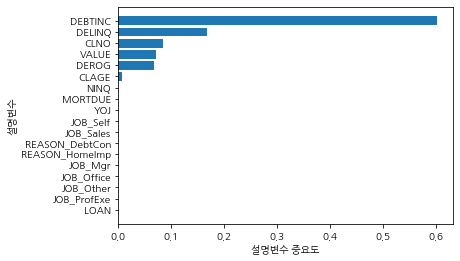

In [116]:
df_importance=pd.DataFrame()
df_importance['Feature']=v_feature_name
df_importance['Importance']=tree_final.feature_importances_

df_importance.sort_values("Importance", ascending=True, inplace=True)
corrdinates =range(len(df_importance))
plt.barh(y=corrdinates, width = df_importance['Importance'])
plt.yticks (corrdinates, df_importance['Feature'])
plt.xlabel('설명변수 중요도')
plt.ylabel('설명변수')

GridSearchCV를 이용한 최적 parameter 찾기

In [ ]:
estimator = DecisionTreeClassifier()

param_grid = {"max_depth":para_depth, "min_samples_split":para_split,
             "min_samples_leaf":para_leaf}

grid_dt = GridSearchCV(esimator, param_grid, scoring="accuracy", n_jobs=-1)
grid_dt.fit(df_train_x, df_train_y)

